In [106]:
import numpy as np
import pandas as pd
import os
from typing import Generator

In [107]:
class LabelData:
    """This class creates one dataset from all sub datasets related to a specified task"""

    def __init__(self, x: str="30"):
        self.path = "label_data"
        self.x = x

    def extract_filenames(self):
        filenames = (item for item in os.listdir(self.path))
        return filenames

    @staticmethod
    def extract_dfs(filenames: Generator):
        dfs = []
        for filename in filenames:
            df = pd.read_excel(f"label_data/{filename}")
            dfs.append(df)
        return dfs

    @staticmethod
    def handling_null_values(dfs: list):
        handled_dfs = []
        for df in dfs:
            df["Task Code (Task ID)"] = df["Task Code (Task ID)"].ffill()
            df["Description"] = df["Description"].ffill()
            handled_dfs.append(df)
        return handled_dfs

    def extract_subsets(self, handled_dfs: list):
        subsets = []
        for df in handled_dfs:
            df_subset = df[df["Task Code (Task ID)"] == f"F11 ({self.x})"]
            subsets.append(df_subset)
        return subsets

    @staticmethod
    def create_new_df(subsets: list):
        new_df = pd.concat(subsets, ignore_index=True)
        return new_df

    def run(self):
        filenames = self.extract_filenames()
        dfs = self.extract_dfs(filenames)
        handled_dfs = self.handling_null_values(dfs)
        subsets = self.extract_subsets(handled_dfs)
        new_df = self.create_new_df(subsets)
        return new_df


In [108]:
class SensorData:
    """This class returns a list with all datasets related to a specified task"""

    def __init__(self, x: str="T30"):
        self.x = x

    def get_sensor_data(self):
        sensor_data = []
        for folder in os.listdir("sensor_data"):
            for filename in os.listdir(f"sensor_data/{folder}"):
                if self.x in filename:
                    df = pd.read_csv(f"sensor_data/{folder}/{filename}")
                    sensor_data.append(df)
        return sensor_data

## Creating instances

In [109]:
label_data = LabelData()
label_data_df = label_data.run()

In [110]:
sensor_data = SensorData()
sensor_data_dfs = sensor_data.get_sensor_data()

## Making sure that there is one dataset for each row in label_data_df

In [201]:
len(label_data_df)

153

In [202]:
len(sensor_data_dfs)

153

## Labeling each frame

In [113]:
def return_label(fc, onset, impact):
    if fc < onset:
        return 0
    elif onset <= fc <= impact:
        return 1
    elif fc > impact:
        return 2

In [114]:
for df in sensor_data_dfs:
    for _, row in label_data_df.iterrows():
        df["Label"] = df["FrameCounter"].apply(lambda fc: return_label(fc, row["Fall_onset_frame"], row["Fall_impact_frame"]))

## Dropping columns that is not needed anymore

In [115]:
for df in sensor_data_dfs:
    df.drop(labels=["TimeStamp(s)", "FrameCounter"], axis=1, inplace=True)

## Making sure there is no missing data

In [116]:
missing_data = [df.notnull().all().all() for df in sensor_data_dfs]

In [117]:
np.False_ in missing_data

False

## Creating one dataset from all sensor data dataframes

In [118]:
final_df = pd.concat(sensor_data_dfs)

In [119]:
final_df

,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,EulerX,EulerY,EulerZ,Label
0,0.069,-1.013,0.144,-0.744845,-34.549367,7.620341,93.008272,-6.371293,-75.928394,0
1,0.069,-1.038,0.143,-0.458366,-34.835846,7.849525,93.048379,-6.422859,-76.277899,0
2,0.063,-1.059,0.141,-0.630254,-34.606663,7.677637,93.082757,-6.468696,-76.627403,0
3,0.047,-1.065,0.150,0.000000,-33.804522,7.677637,93.128593,-6.520262,-76.965448,0
4,0.037,-1.057,0.165,1.203212,-32.314831,8.021412,93.197348,-6.537451,-77.286305,0
...,...,...,...,...,...,...,...,...,...,...
851,0.479,0.016,-0.882,0.572958,-1.489691,-0.171887,-0.893814,26.665465,-2.440801,2
852,0.480,0.018,-0.882,0.286479,-1.489691,0.057296,-0.888085,26.654006,-2.440801,2
853,0.478,0.021,-0.883,0.000000,-1.546987,0.114592,-0.888085,26.636817,-2.435072,2
854,0.474,0.024,-0.880,-0.114592,-1.718874,0.057296,-0.996947,26.665465,-2.486638,2


## DEA

In [120]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107993 entries, 0 to 855
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AccX    107993 non-null  float64
 1   AccY    107993 non-null  float64
 2   AccZ    107993 non-null  float64
 3   GyrX    107993 non-null  float64
 4   GyrY    107993 non-null  float64
 5   GyrZ    107993 non-null  float64
 6   EulerX  107993 non-null  float64
 7   EulerY  107993 non-null  float64
 8   EulerZ  107993 non-null  float64
 9   Label   107993 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 9.1 MB


In [121]:
final_df.corr()

,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,EulerX,EulerY,EulerZ,Label
AccX,1.000000,0.125095,-0.183538,-0.033628,-0.160281,-0.128674,-0.131561,0.608018,0.104919,0.097990
AccY,0.125095,1.000000,-0.717677,0.080352,0.008419,-0.008499,-0.839883,0.173587,-0.005688,0.557707
AccZ,-0.183538,-0.717677,1.000000,0.025798,0.037809,-0.000084,0.824500,-0.148803,0.023699,-0.582468
GyrX,-0.033628,0.080352,0.025798,1.000000,0.016556,0.139701,-0.014233,-0.035516,-0.043161,0.174170
GyrY,-0.160281,0.008419,0.037809,0.016556,1.000000,-0.112227,0.035122,-0.030166,0.067501,-0.014879
GyrZ,-0.128674,-0.008499,-0.000084,0.139701,-0.112227,1.000000,-0.013769,-0.239481,-0.134820,0.027213
EulerX,-0.131561,-0.839883,0.824500,-0.014233,0.035122,-0.013769,1.000000,-0.195818,0.002499,-0.723954
EulerY,0.608018,0.173587,-0.148803,-0.035516,-0.030166,-0.239481,-0.195818,1.000000,0.138050,0.153880
EulerZ,0.104919,-0.005688,0.023699,-0.043161,0.067501,-0.134820,0.002499,0.138050,1.000000,0.018005
Label,0.097990,0.557707,-0.582468,0.174170,-0.014879,0.027213,-0.723954,0.153880,0.018005,1.000000


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

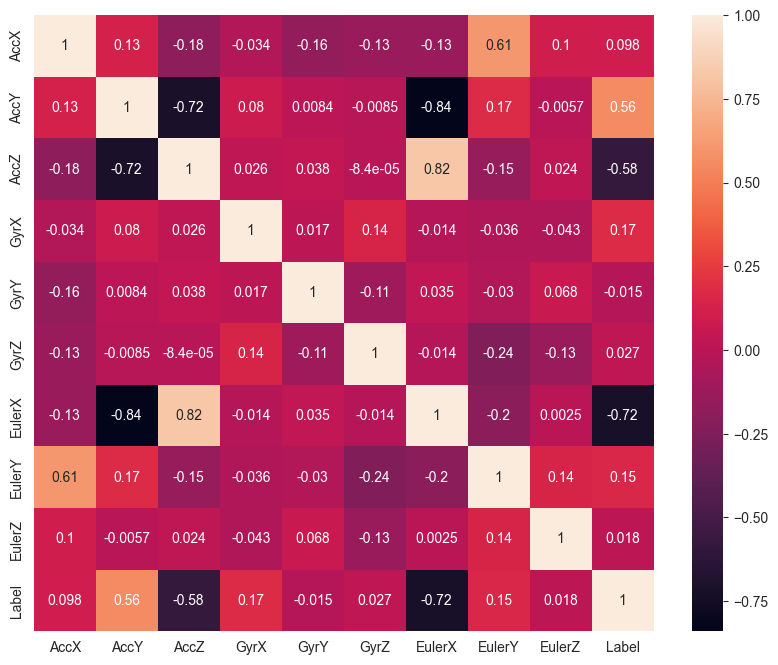

In [123]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=final_df.corr(), annot=True)
plt.show()

In [124]:
final_df_subset = final_df[["EulerX", "AccZ", "AccY", "Label"]]

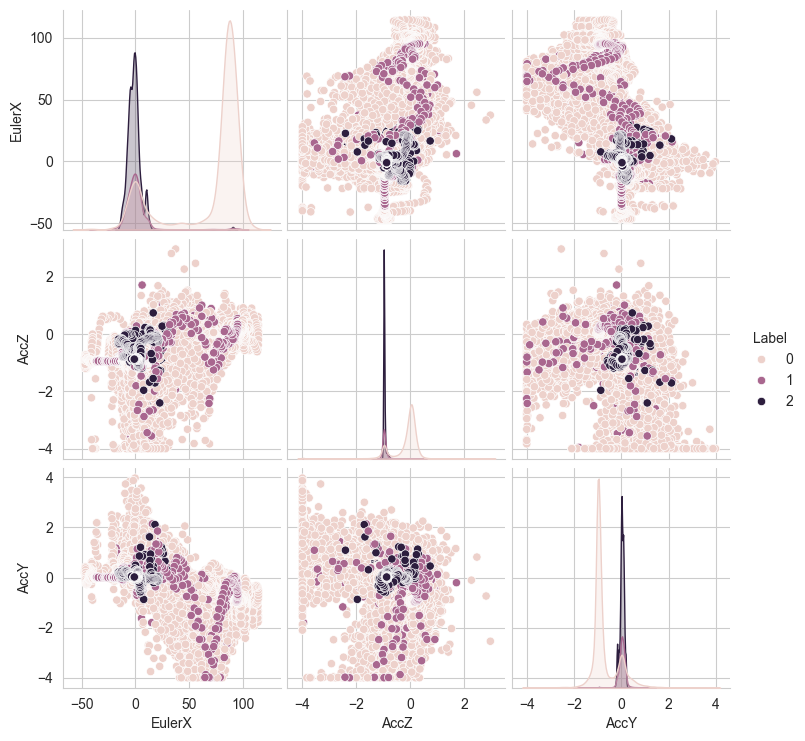

In [125]:
sns.pairplot(data=final_df_subset, hue="Label");

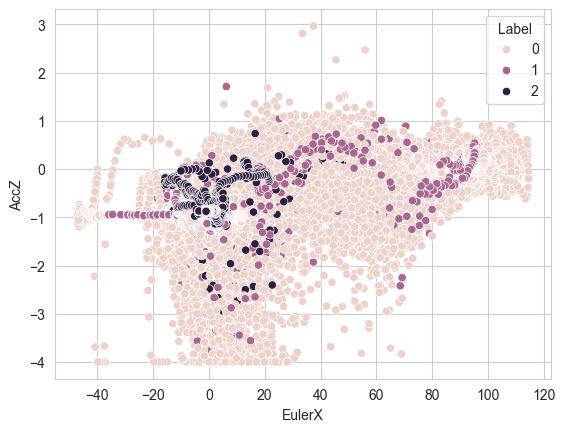

In [126]:
sns.scatterplot(x=final_df["EulerX"], y=final_df["AccZ"], hue=final_df["Label"]);

## Xy

In [178]:
X = final_df.drop("Label", axis=1)
y = final_df["Label"]

## Train test split

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create pipeline

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [182]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [183]:
operations = [('scaler', scaler),('knn', knn)]

In [184]:
pipe = Pipeline(operations)

## GridSearchCV

In [189]:
from sklearn.model_selection import GridSearchCV

In [190]:
param_grid = {
    "knn__n_neighbors": np.arange(1, 21),
    "knn__metric": ['euclidean', 'manhattan', 'chebyshev']
}

In [191]:
grid_model = GridSearchCV(estimator=pipe,param_grid=param_grid,scoring='accuracy')

## Fit model

In [193]:
grid_model.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

## Predict

In [198]:
y_pred = grid_model.predict(X_test)

## Evaluate

In [199]:
from sklearn.metrics import classification_report

In [196]:
print(classification_report(y_test,y_pred, zero_division=0.0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13615
           1       0.98      0.97      0.98      2367
           2       0.99      1.00      0.99      5617

    accuracy                           0.99     21599
   macro avg       0.99      0.99      0.99     21599
weighted avg       0.99      0.99      0.99     21599

